# Lab 02: Softmax Regression - Model Implementation

**Group 09:** 
**Members:**
1. Bùi Huy Giáp - 23127289
2. Lê Minh Đức - 23127351
3. Vũ Tiến Dũng - 23127354
4. Đinh Xuân Khương - 23127398
5. Nguyễn Đồng Thanh - 23127538 

---

## 1. Introduction
In this notebook, we implement the **Softmax Regression** model from scratch using only `NumPy`. This model is a generalization of Logistic Regression for multi-class classification problems. We will use the MNIST dataset (handwritten digits 0-9) to train and evaluate our model.

The goal is to understand the underlying mathematics:
1.  **Linear Hypothesis:** $z = Wx + b$
2.  **Softmax Activation:** Converting raw scores into probabilities.
3.  **Cross-Entropy Loss:** Measuring the difference between predicted probabilities and actual labels.
4.  **Gradient Descent:** Updating parameters ($W, b$) to minimize loss.

## 2. Mathematical Formulation

### 2.1. Hypothesis
For a given input vector $x \in \mathbb{R}^{d}$ (where $d$ is the number of features, e.g., $28 \times 28 = 784$ pixels), and for $K$ classes (here $K=10$), the model computes a linear score (logit) for each class $k$:

$$z_k = w_k^T x + b_k$$

In vectorized form for a batch of $m$ samples $X \in \mathbb{R}^{m \times d}$:
$$Z = XW + b$$
Where:
- $W \in \mathbb{R}^{d \times K}$ is the weight matrix.
- $b \in \mathbb{R}^{1 \times K}$ is the bias vector.
- $Z \in \mathbb{R}^{m \times K}$ contains the logits.

### 2.2. Softmax Function
To transform logits $Z$ into valid probabilities $\hat{Y}$ (where elements sum to 1), we use the Softmax function:

$$\hat{y}_k = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}$$

**Numerical Stability:**
Directly computing $e^{z_k}$ can lead to overflow if $z_k$ is large. To prevent this, we subtract the maximum logit from $Z$ before exponentiation:
$$\text{Softmax}(z)_k = \frac{e^{z_k - \max(z)}}{\sum_{j=1}^{K} e^{z_j - \max(z)}}$$

### 2.3. Cross-Entropy Loss
We optimize the model by minimizing the Cross-Entropy loss. For a single sample with true label $y$ (one-hot encoded) and prediction $\hat{y}$:

$$L(y, \hat{y}) = - \sum_{k=1}^{K} y_k \log(\hat{y}_k)$$

Average loss over batch of size $m$:
$$J(W, b) = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y^{(i)}_k \log(\hat{y}^{(i)}_k)$$

### 2.4. Optimization (Gradient Descent)
We compute the gradients of the loss function with respect to weights $W$ and bias $b$.
Using the chain rule, the gradient of the loss with respect to logits $Z$ is:
$$\frac{\partial J}{\partial Z} = \hat{Y} - Y$$

Thus, the gradients for parameters are:
$$\frac{\partial J}{\partial W} = \frac{1}{m} X^T (\hat{Y} - Y)$$
$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})$$

Update rule:
$$W := W - \alpha \frac{\partial J}{\partial W}$$
$$b := b - \alpha \frac{\partial J}{\partial b}$$
Where $\alpha$ is the learning rate.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request # Standard library for downloading files

# Set random seed for reproducibility
np.random.seed(42)


## 3. Data Loading & Helper Functions

We need to load the MNIST dataset. To ensure efficiency and portability, we will download the dataset in `.npz` (NumPy Zip) format directly from a reliable source (Google Cloud Storage) if it is not already available locally.

We implement the following preprocessing steps:
1.  **Loading:** Read `x_train`, `y_train`, `x_test`, `y_test` from the `.npz` file.
2.  **Normalization:** Scale pixel intensity values from the range $[0, 255]$ to $[0, 1]$ to ensure numerical stability during gradient descent.
3.  **Flattening:** Reshape each $28 \times 28$ image matrix into a flat feature vector of size $784$ ($28 \times 28 = 784$). This allows us to perform matrix multiplication with our weight matrix $W$.
4.  **One-hot encoding:** Convert integer labels (e.g., $y=5$) into binary vectors (e.g., $[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]$) for Cross-Entropy loss calculation.

In [4]:
def load_mnist_data(data_path='../data/raw/mnist.npz'):
    """
    Downloads and loads the MNIST dataset from a .npz file.
    If the file does not exist, it downloads it from Google Cloud.
    
    Args:
        data_path (str): Path to save/load the .npz file.
        
    Returns:
        x_train, y_train, x_test, y_test: Numpy arrays.
        - x_train: (60000, 784) - Normalized and Flattened
        - y_train: (60000,)     - Raw labels
        - x_test:  (10000, 784) - Normalized and Flattened
        - y_test:  (10000,)     - Raw labels
    """
    # 1. Download if not exists
    url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz"
    
    # Ensure directory exists
    directory = os.path.dirname(data_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")

    if not os.path.exists(data_path):
        print(f"Downloading MNIST data from {url}...")
        try:
            urllib.request.urlretrieve(url, data_path)
            print("Download complete.")
        except Exception as e:
            print(f"Download failed: {e}")
            return None, None, None, None
    else:
        print(f"Loading data from {data_path}...")

    # 2. Load data using numpy
    with np.load(data_path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']

    print(f"Original x_train shape: {x_train.shape}") # Expected: (60000, 28, 28)
    
    # 3. Preprocessing: Normalize and Flatten
    # Scale pixel values to [0, 1] (float32)
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0
    
    # Flatten images: (N, 28, 28) -> (N, 784)
    # This is CRITICAL for matrix multiplication: Z = XW + b
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    
    print(f"Processed x_train shape: {x_train.shape}") # Expected: (60000, 784)
    print(f"Processed x_test shape: {x_test.shape}")   # Expected: (10000, 784)
    
    return x_train, y_train, x_test, y_test

def one_hot_encode(y, num_classes=10):
    """
    Converts integer labels to one-hot encoded vectors.
    e.g., 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    
    Args:
        y (numpy.ndarray): Array of integer labels (m,).
        num_classes (int): Number of classes.
        
    Returns:
        numpy.ndarray: One-hot encoded matrix (m, num_classes).
    """
    m = y.shape[0]
    one_hot = np.zeros((m, num_classes))
    for i in range(m):
        one_hot[i, y[i]] = 1
    return one_hot

# --- EXECUTE LOADING ---
try:
    # Load data
    X_train_full, y_train_full, X_test, y_test = load_mnist_data()
    
    if X_train_full is not None:
        # Create a Validation set from Train set (last 5000 samples)
        # We split to tune hyperparameters without touching the Test set
        val_size = 5000
        X_val = X_train_full[-val_size:]
        y_val = y_train_full[-val_size:]
        
        X_train = X_train_full[:-val_size]
        y_train = y_train_full[:-val_size]
        
        # One-hot encode labels for training
        y_train_enc = one_hot_encode(y_train)
        y_val_enc = one_hot_encode(y_val)
        y_test_enc = one_hot_encode(y_test)
        
        print("\nDataset ready for training:")
        print(f"Training set:   X={X_train.shape}, y={y_train_enc.shape}")
        print(f"Validation set: X={X_val.shape}, y={y_val_enc.shape}")
        print(f"Test set:       X={X_test.shape}, y={y_test_enc.shape}")
    else:
        print("Failed to load dataset.")

except Exception as e:
    print(f"An error occurred: {e}")

Download complete.
Original x_train shape: (60000, 28, 28)
Processed x_train shape: (60000, 784)
Processed x_test shape: (10000, 784)

Dataset ready for training:
Training set:   X=(55000, 784), y=(55000, 10)
Validation set: X=(5000, 784), y=(5000, 10)
Test set:       X=(10000, 784), y=(10000, 10)


## 4. Softmax Regression Implementation

This is the core component of the project. The class encapsulates the logic derived in Section 2.

**Key Implementation Details:**
* **Numerical Stability:** We implement `softmax` by subtracting the maximum value from logits to avoid floating-point overflow.
* **Mini-batch Gradient Descent:** Instead of updating weights after seeing the whole dataset (Batch GD) or a single example (SGD), we update after a small batch (e.g., 256 samples). This balances speed and stability.
* **Vectorization:** We use NumPy matrix operations (dot products) instead of `for` loops wherever possible for performance.

In [5]:
class SoftmaxRegression:
    def __init__(self, n_features, n_classes, learning_rate=0.01):
        """
        Initializes the Softmax Regression model parameters.

        Args:
            n_features (int): Number of input features (e.g., 784 for MNIST).
            n_classes (int): Number of output classes (e.g., 10 for MNIST).
            learning_rate (float): Step size for Gradient Descent optimization.
        """
        self.n_features = n_features
        self.n_classes = n_classes
        self.lr = learning_rate
        self.losses = []
        
        # Initialize weights and bias
        # W: (n_features, n_classes) - Initialized with small random values
        self.W = np.random.randn(n_features, n_classes) * 0.01
        
        # b: (1, n_classes) - Initialized with zeros
        self.b = np.zeros((1, n_classes))

    def softmax(self, z):
        """
        Computes the softmax activation function with numerical stability.
        Formula: exp(z_i) / sum(exp(z_j))

        Args:
            z (numpy.ndarray): Linear logits (batch_size, n_classes).

        Returns:
            numpy.ndarray: Probabilities (batch_size, n_classes).
        """
        # Subtract max value to prevent overflow (Numerical Stability)
        z_stable = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        """
        Performs the forward pass to compute predictions.
        
        Args:
            X (numpy.ndarray): Input data (batch_size, n_features).

        Returns:
            numpy.ndarray: Predicted probabilities.
        """
        # Linear transformation: Z = XW + b
        z = np.dot(X, self.W) + self.b
        # Activation
        return self.softmax(z)

    def compute_loss(self, y_true, y_pred):
        """
        Computes Cross-Entropy Loss.
        L = - sum(y_true * log(y_pred))

        Args:
            y_true (numpy.ndarray): One-hot encoded ground truth.
            y_pred (numpy.ndarray): Predicted probabilities.

        Returns:
            float: Average loss over the batch.
        """
        m = y_true.shape[0]
        # Add a small epsilon to avoid log(0) error
        epsilon = 1e-9
        loss = -np.sum(y_true * np.log(y_pred + epsilon)) / m
        return loss

    def backward(self, X, y_true, y_pred):
        """
        Computes gradients of the loss with respect to W and b.

        Args:
            X (numpy.ndarray): Input data batch.
            y_true (numpy.ndarray): One-hot encoded ground truth.
            y_pred (numpy.ndarray): Predicted probabilities.

        Returns:
            dw, db: Gradients for weights and bias.
        """
        m = X.shape[0]
        
        # Gradient of loss w.r.t Z (logits) is simply (Prediction - Truth)
        dz = y_pred - y_true
        
        # Gradients w.r.t parameters
        # dW = (1/m) * X.T . dZ
        dw = np.dot(X.T, dz) / m
        # db = (1/m) * sum(dZ)
        db = np.sum(dz, axis=0, keepdims=True) / m
        
        return dw, db

    def fit(self, X, y, epochs=100, batch_size=256, verbose=True):
        """
        Trains the model using Mini-batch Gradient Descent.

        Args:
            X (numpy.ndarray): Training features (m, n_features).
            y (numpy.ndarray): Training labels One-hot (m, n_classes).
            epochs (int): Number of passes over the entire dataset.
            batch_size (int): Number of samples per gradient update.
        """
        m = X.shape[0]
        self.losses = [] # Reset history

        for epoch in range(epochs):
            # Shuffle data at the start of each epoch to ensure randomness
            indices = np.arange(m)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0
            num_batches = int(np.ceil(m / batch_size))

            for i in range(num_batches):
                start_idx = i * batch_size
                end_idx = min(start_idx + batch_size, m)
                
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # 1. Forward pass
                y_pred = self.forward(X_batch)

                # 2. Compute Loss (accumulate for reporting)
                loss = self.compute_loss(y_batch, y_pred)
                epoch_loss += loss * (end_idx - start_idx) 

                # 3. Backward pass
                dw, db = self.backward(X_batch, y_batch, y_pred)

                # 4. Update parameters
                self.W -= self.lr * dw
                self.b -= self.lr * db
            
            # Average loss for the epoch
            avg_loss = epoch_loss / m
            self.losses.append(avg_loss)
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    def predict(self, X):
        """
        Predicts class labels for input data.

        Args:
            X (numpy.ndarray): Input data (N, n_features).

        Returns:
            numpy.ndarray: Predicted class indices (N,).
        """
        y_pred_probs = self.forward(X)
        return np.argmax(y_pred_probs, axis=1)
    
    def save_weights(self, filepath):
        """Saves model weights to a .npz file."""
        # Ensure directory exists
        directory = os.path.dirname(filepath)
        if directory and not os.path.exists(directory):
            os.makedirs(directory)
            
        np.savez(filepath, W=self.W, b=self.b)
        print(f"Model saved to {filepath}")

    def load_weights(self, filepath):
        """Loads model weights from a .npz file."""
        if not os.path.exists(filepath):
            print(f"File not found: {filepath}")
            return
            
        data = np.load(filepath)
        self.W = data['W']
        self.b = data['b']
        print(f"Model loaded from {filepath}")

## 5. Sanity Check (Overfitting Test)

Before training on the full 55,000 images, we perform a **Sanity Check**. 
We take a tiny subset of real data (e.g., 100 images) and train the model for many epochs. 

* **Goal:** The model should be able to memorize this small dataset perfectly (Loss $\to$ 0, Accuracy $\to$ 100%).
* **Result:** If the model fails to overfit this small batch, there is a bug in the code (likely in Gradient Descent or Backpropagation).

Sanity check subset: (100, 784)

Starting Sanity Check...
Epoch 10/200 - Loss: 0.3846
Epoch 20/200 - Loss: 0.1783
Epoch 30/200 - Loss: 0.1117
Epoch 40/200 - Loss: 0.0802
Epoch 50/200 - Loss: 0.0624
Epoch 60/200 - Loss: 0.0512
Epoch 70/200 - Loss: 0.0432
Epoch 80/200 - Loss: 0.0375
Epoch 90/200 - Loss: 0.0330
Epoch 100/200 - Loss: 0.0295
Epoch 110/200 - Loss: 0.0267
Epoch 120/200 - Loss: 0.0244
Epoch 130/200 - Loss: 0.0224
Epoch 140/200 - Loss: 0.0207
Epoch 150/200 - Loss: 0.0193
Epoch 160/200 - Loss: 0.0181
Epoch 170/200 - Loss: 0.0170
Epoch 180/200 - Loss: 0.0160
Epoch 190/200 - Loss: 0.0152
Epoch 200/200 - Loss: 0.0144

Sanity Check Accuracy: 100.00%
✅ Sanity Check PASSED: Model logic is correct.


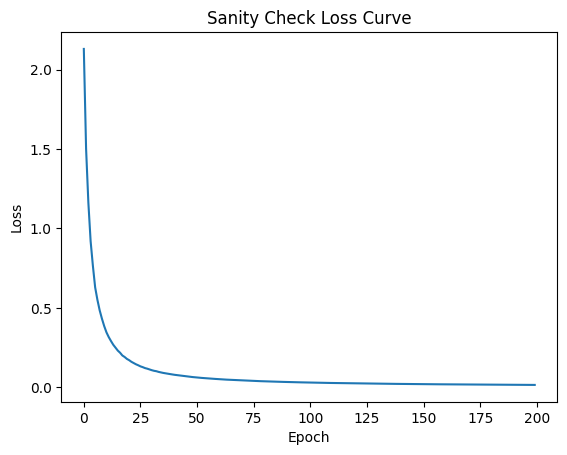

In [7]:
# 1. Select a small subset of REAL data
subset_size = 100
X_subset = X_train[:subset_size]
y_subset_enc = y_train_enc[:subset_size]
y_subset_labels = y_train[:subset_size] # Original labels for accuracy check

print(f"Sanity check subset: {X_subset.shape}")

# 2. Initialize Model
# 784 features (pixels), 10 classes (digits 0-9)
model_test = SoftmaxRegression(n_features=784, n_classes=10, learning_rate=0.1)

# 3. Train on subset (Overfitting)
print("\nStarting Sanity Check...")
model_test.fit(X_subset, y_subset_enc, epochs=200, batch_size=20, verbose=True)

# 4. Check Prediction Accuracy
preds = model_test.predict(X_subset)
acc = np.mean(preds == y_subset_labels)
print(f"\nSanity Check Accuracy: {acc * 100:.2f}%")

# 5. Evaluate
if acc > 0.95:
    print("✅ Sanity Check PASSED: Model logic is correct.")
else:
    print("❌ Sanity Check FAILED: Model cannot learn even small data.")

# 6. Visualize Loss Curve
plt.plot(model_test.losses)
plt.title("Sanity Check Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### 5.1. Sanity Check Analysis & Discussion

**Observation:**
As shown in the loss curve above, the training loss decreased significantly from an initial high value to near zero (~0.0144) after 200 epochs. The model achieved **100% accuracy** on the subset of 100 samples.

**Discussion on Overfitting:**
We observe that the model has successfully **overfitted** this small subset. In the context of a Sanity Check, this is a **positive outcome** because:
1.  **Verification of Code Logic:** It confirms that the Forward pass, Backward pass (Gradient calculation), and Update rules are implemented correctly without bugs. If the code were broken, the model would fail to converge even on this tiny dataset.
2.  **Model Capacity:** It demonstrates that our Linear Model (Softmax Regression) has sufficient capacity to memorize the mapping of inputs to labels for a small data sample.

**Conclusion:**
The core implementation is mathematically correct. We can now proceed to training on the full dataset, where our goal will shift from *memorization* (overfitting) to *generalization* (performing well on unseen Test data).